# ArrowHead clustering

This notebook presents the results of the clustering of the ArrowHead dataset using diverse methods implemented in Python.

In [1]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.clustering.optimalK.bic import BIC
from FDApy.preprocessing.dim_reduction.fpca import UFPCA, MFPCA
from FDApy.representation.functional_data import DenseFunctionalData, IrregularFunctionalData, MultivariateFunctionalData
from FDApy.misc.loader import read_csv, read_ts
from FDApy.visualization.plot import plot

from skfda import FDataGrid
from skfda.datasets import make_multimodal_landmarks
from skfda.preprocessing.registration import landmark_registration_warping
from skfda.ml.clustering import KMeans

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#5d8aa8', '#e32636',
          '#e52b50', '#ffbf00', '#ff033e', '#9966cc',
          '#a4c639', '#cd9575', '#915c83', '#008000',
          '#00ffff', '#4b5320', '#a52a2a', '#fdee00',
          '#ff2052', '#007fff', '#ffe135']

In [2]:
def plot_labels(data, labels):
    """Plot functional with different colors for different labels."""
    fig, ax = plt.subplots()
    for o, i in zip(data.values, labels):
        ax.plot(data.argvals['input_dim_0'], o, c=COLORS[i])
    return fig, ax

In [3]:
X = pd.read_csv('./data/MNIST.csv', header=None)
X_mat = X.values

X_dim_0 = X_mat[:, :100]
X_dim_1 = X_mat[:, 100:200]
labels = X_mat[:, 200].astype('int')
time = np.linspace(0, 1, X_dim_0.shape[1])

In [4]:
# Remove the label 2, 3, 4, 6, 8, 9 because of the few number of observations
two, = np.where(labels == 2)
three, = np.where(labels == 3)
four, = np.where(labels == 4)
six, = np.where(labels == 6)
eight, = np.where(labels == 8)
nine, = np.where(labels == 9)
bad_obs = np.concatenate((two, three, four,
                          six, eight, nine))
X_dim_0 = np.delete(X_dim_0, obj=bad_obs, axis=0)
X_dim_1 = np.delete(X_dim_1, obj=bad_obs, axis=0)
labels = np.delete(labels, obj=bad_obs)

In [19]:
# Remove inconsistency in the observations
# due to a wrong pre-coding of the time vector.
#X_dim_0[(X_dim_0[:, 0] > 0.5) & labels == 0]


array([[0.2679, 0.2559, 0.2439, ..., 0.3036, 0.3036, 0.3036],
       [0.2679, 0.2679, 0.2679, ..., 0.6399, 0.6324, 0.625 ],
       [0.3036, 0.2938, 0.284 , ..., 0.3589, 0.3491, 0.3393],
       ...,
       [0.1964, 0.1964, 0.1964, ..., 0.8393, 0.8393, 0.8393],
       [0.2679, 0.2679, 0.2679, ..., 0.2321, 0.2321, 0.2321],
       [0.3036, 0.3036, 0.3036, ..., 0.2679, 0.2679, 0.2679]])

In [5]:
data_dim_0 = DenseFunctionalData({'input_dim_0': time}, X_dim_0)
data_dim_1 = DenseFunctionalData({'input_dim_0': time}, X_dim_1)

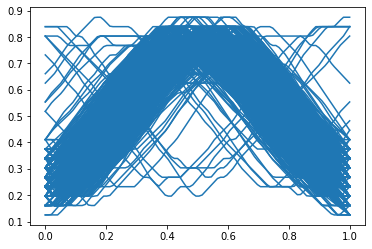

In [18]:
_ = plot_labels(data_dim_0[labels==0], labels[labels==0])

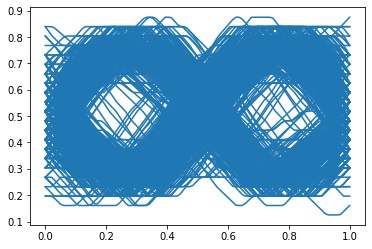

In [19]:
_ = plot_labels(data_dim_1[labels==0], labels[labels==0])

In [8]:
data_fd = MultivariateFunctionalData([data_dim_0, data_dim_1])

In [9]:
print(f'Number of observations: {data_fd.n_obs}.')
print(f'Number of points: {data_fd.n_points}.')

Number of observations: 2803.
Number of points: [{'input_dim_0': 100}, {'input_dim_0': 100}].


In [10]:
# Do MFPCA on the data for clustering
fpca = MFPCA(n_components=[2, 2])
fpca.fit(data_fd)

# Compute scores
simu_proj = fpca.transform(data_fd, method='NumInt')

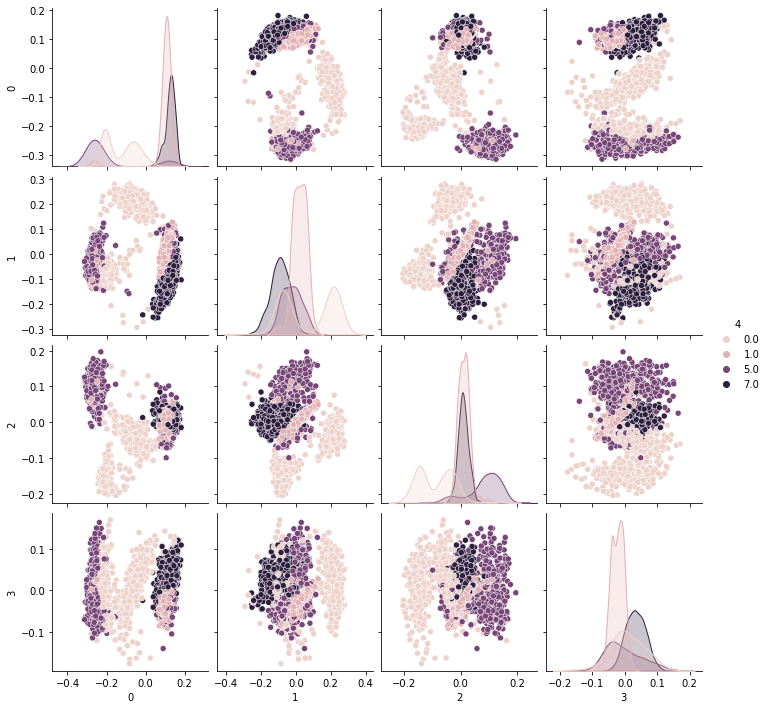

In [11]:
_ = sns.pairplot(pd.DataFrame(np.hstack([simu_proj, labels[:, np.newaxis]])),
                 hue=simu_proj.shape[1], diag_kind='kde')

In [12]:
%%time
# Perform fCUBT
root_node = Node(data_fd, is_root=True)
fcubt = FCUBT(root_node=root_node)
fcubt.grow(n_components=[1, 1], min_size=200, max_group=5)

CPU times: user 45.7 s, sys: 25.7 s, total: 1min 11s
Wall time: 24.2 s


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

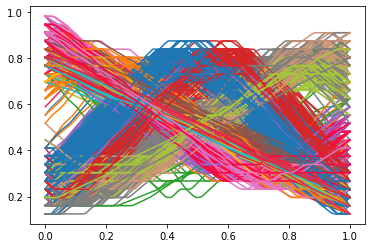

In [13]:
plot_labels(data_fd[0], fcubt.labels_grow)

In [14]:
adjusted_rand_score(labels, fcubt.labels_grow)

0.35331064069447343

In [15]:
%%time
fcubt.join(n_components=[1, 1], max_group=4)

CPU times: user 15min 5s, sys: 9min 5s, total: 24min 11s
Wall time: 8min 9s


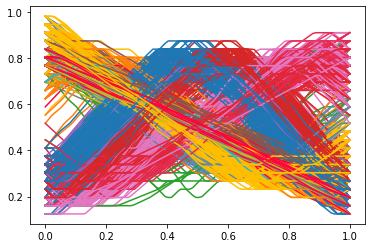

In [16]:
_ = plot_labels(data_fd[0], fcubt.labels_join)

In [17]:
adjusted_rand_score(labels, fcubt.labels_join)

0.4639604852397454